In [53]:
%pdb off
%matplotlib inline
from shared import *
import make_slr_scenario
import make_slr_cari

Automatic pdb calling has been turned OFF


In [41]:
path_wd = Path.cwd() / 'TEST'
region  = 'Central' 
use_vlm = True
use_s2  = False
scen_test = 'Int2100'
vlm_ext = '_vlm' if use_vlm else ''
print ('Region:', region)
print ('Scenario:', scen_test)
assert path_wd.exists(), 'Cant find the test directory'

Region: Central
Scenario: Int2100


In [55]:
# make the CARI polygons from the downloaded database
make_cari_habitats(path_wd, 'Coastal_Habitats_v2.gdb')

/home/buzzanga/Miniforge3/envs/SL/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/CARI_polygons/Cari_Beach.GeoJSON
Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/CARI_polygons/Cari_Rocky.GeoJSON


In [16]:
# apply the SLR scenarios and VLM
make_slr_scenario.main(path_wd, 2100, vlm=use_vlm)

Using existing VLM
INFO:   main:84     [Oct 29, 12:11:45] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/tidal_datums/MLLW_SLR_0_VLM.tif
INFO:   main:84     [Oct 29, 12:11:46] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/tidal_datums/MLLW_SLR_Low2100_VLM.tif
INFO:   main:84     [Oct 29, 12:11:46] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/tidal_datums/MLLW_SLR_IntLow2100_VLM.tif
INFO:   main:84     [Oct 29, 12:11:46] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/tidal_datums/MLLW_SLR_Int2100_VLM.tif
INFO:   main:84     [Oct 29, 12:11:47] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/tidal_datums/MLLW_SLR_IntHigh2100_VLM.tif
INFO:   main:84     [Oct 29, 12:11:47] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/tidal_datums/MLLW_SLR_High2100_VLM.tif
INFO:   main:84     [Oct 29, 12:11:47] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/tidal_datums/MAH_SLR_0_VLM.tif
INFO:   main:84     [Oct 29, 12:11:47] Wrote: /home/buzzanga/Software_SL/cariSLR_git/TEST/

In [21]:
# test the algorithm on a single polygon; the answer should be Lost: 33.859% for Int2100 Cental beaches (polygon=52, tile=CentCA_south_Topobathy_CoNED_1m_C4)
da_dem_test, da_mllw0_test, da_mllw_slr_test, df_slr_test, poly_test = make_slr_cari.main(region, 'beach', scen_test, path_wd, use_vlm, use_s2, test=True)

/home/buzzanga/Miniforge3/envs/SL/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: ERROR parsing kml Style: No id
  return ogr_read(


INFO:   get_enso_map:225    [Oct 29, 12:22:49] Wrote enso to dem map for EPSG: 3717

INFO:   main:133    [Oct 29, 12:23:00] 117 beach polygons within CentCA_south_Topobathy_CoNED_1m_C4
CRITICAL:   main:170    [Oct 29, 12:23:40] CentCA_south_Topobathy_CoNED_1m_C4, polyix=10 cari id=10:
CRITICAL:   compare_elevations_poly:85     [Oct 29, 12:23:57] 	100.000% ABOVE MLLW today; 100.000 in Int2100. 	Lost: 0.000% 
CRITICAL:   main:170    [Oct 29, 12:24:12] CentCA_south_Topobathy_CoNED_1m_C4, polyix=52 cari id=52:
CRITICAL:   compare_elevations_poly:85     [Oct 29, 12:24:28] 	99.749% ABOVE MLLW today; 65.890 in Int2100. 	Lost: 33.859% 


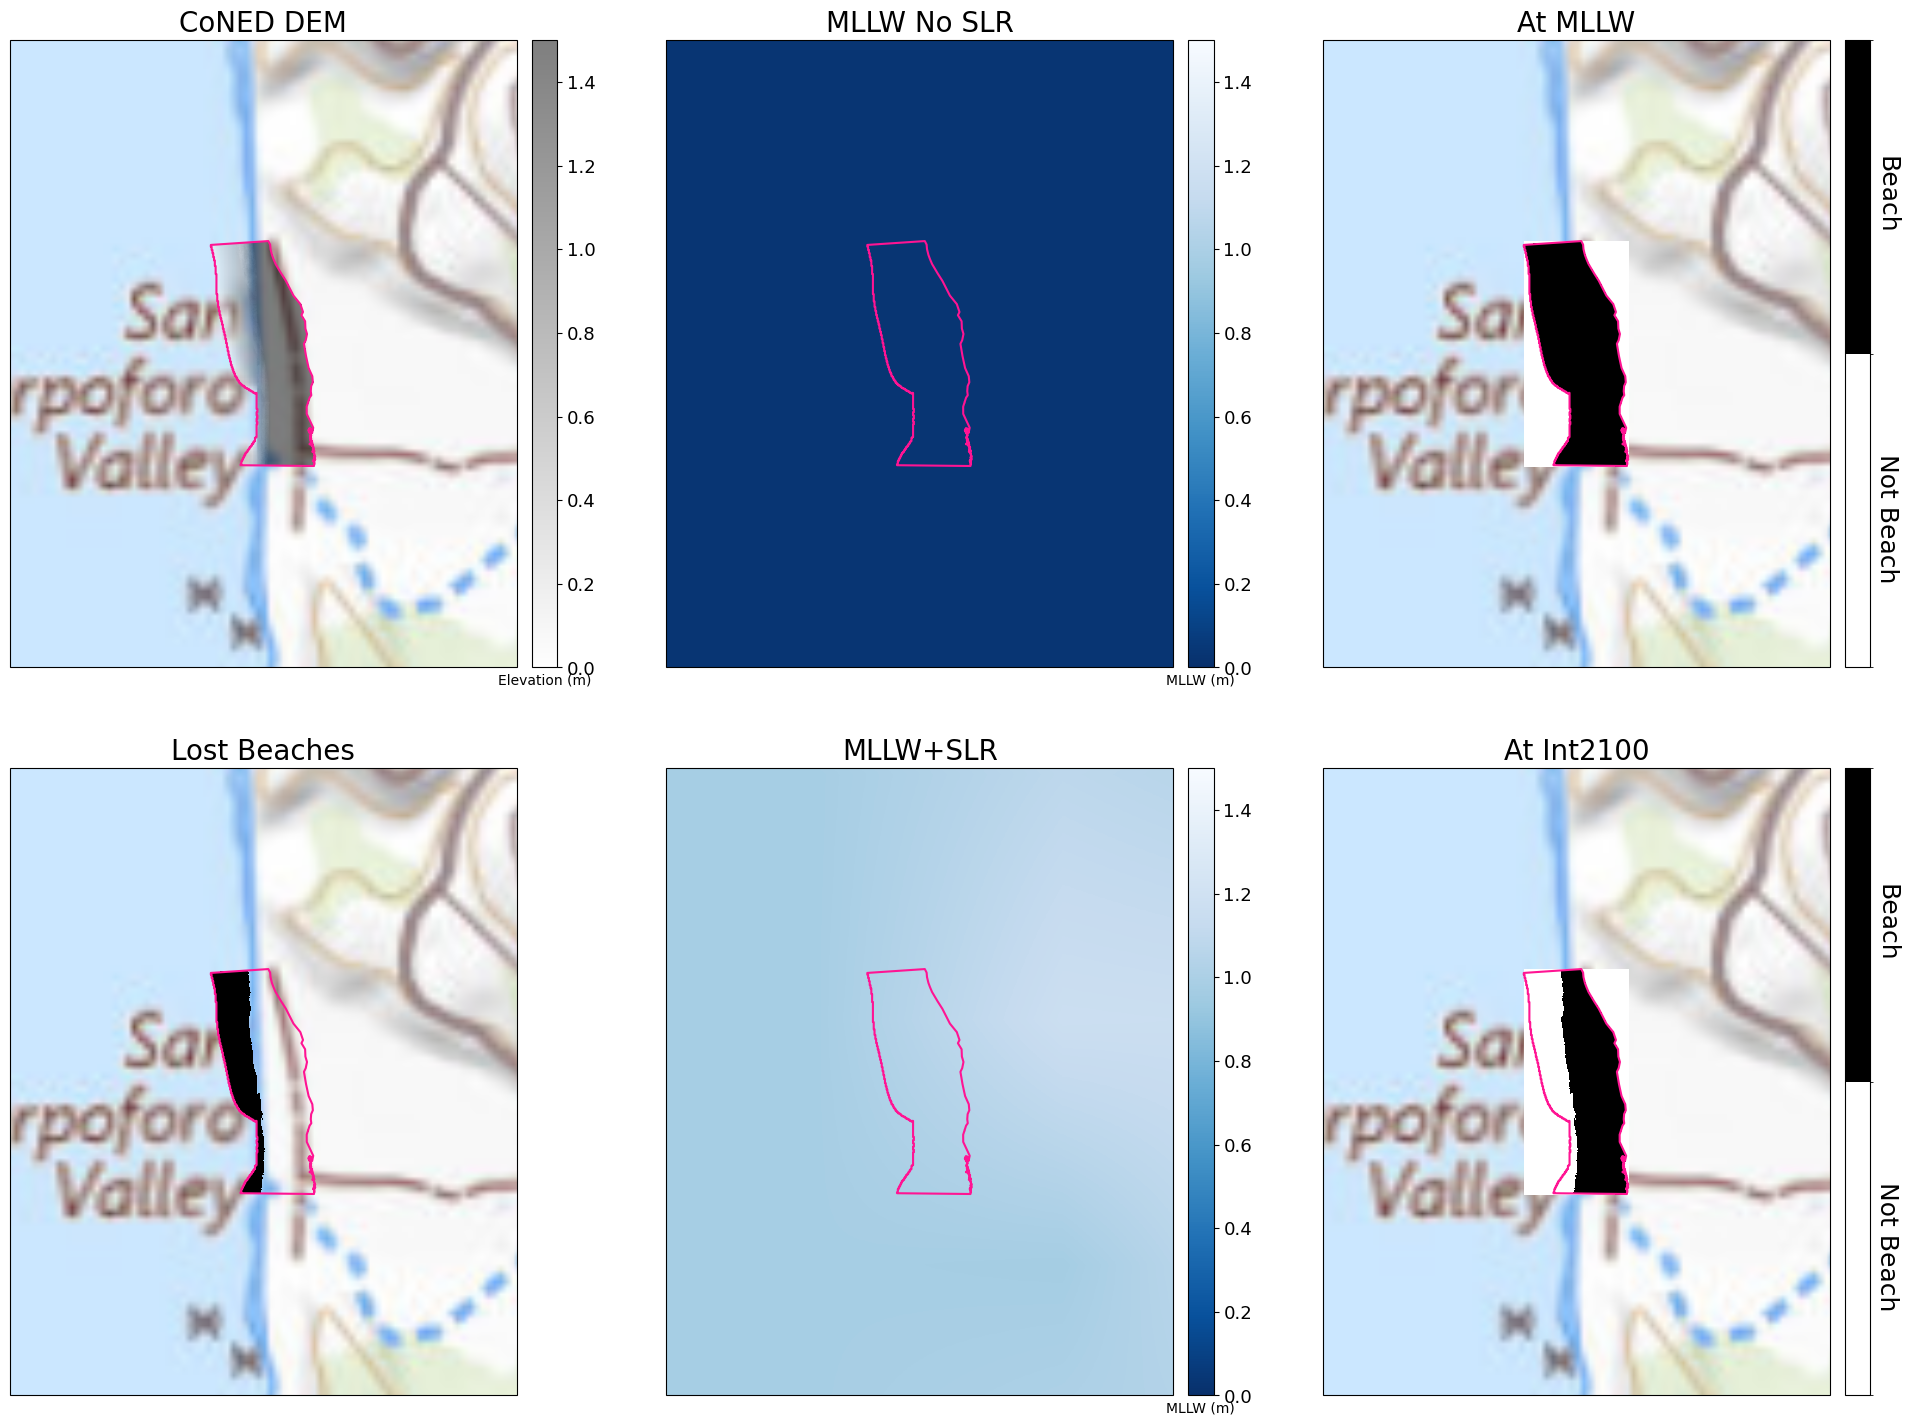

In [28]:
proju = dct_proju[region]
# get bounds and buffer for plot extent
buff     = 2.5e2 
wd, sd, ed, nd = da_dem_test.rio.bounds()

da_mask0 = da_dem_test > da_mllw0_test # original beaches
da_mask1 = da_dem_test > da_mllw_slr_test # new beaches
da_resid = da_mask0.astype(int) - da_mask1.astype(int)
da_resid = xr.where(da_resid>0, -1, np.nan) # show the new underwater locations

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 24), subplot_kw={'projection':proju})

for ax in axes.ravel():
    ax.set_extent([wd-buff,ed+buff,sd-buff,nd+buff], crs=ccrs.UTM(10))
    # cx.add_basemap(ax=ax, crs=da_dem2.rio.crs, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=13)
    cx.add_basemap(ax=ax, crs=da_dem_test.rio.crs, source=cxbasemap_t, attribution=False, zoom=14)
    ax.add_geometries([poly_test], zorder=11, crs=proju, linewidth=1.5, **sty_cari)

sty = dict(shading='nearest', transform=ccrs.UTM(10), cmap='binary', norm=mpl.colors.Normalize(0, 1.5))
## dem
im = axes[0, 0].pcolormesh(da_dem_test.x, da_dem_test.y, da_dem_test, alpha=0.5, **sty)
bbPlot.cartopy_cbar(im, f'Elevation (m)')
axes[0,0].set_title('CoNED DEM', fontsize=TFS)

## residual
sty['cmap'] = 'binary_r'
im = axes[1, 0].pcolormesh(da_resid.x, da_resid.y, da_resid, **sty)
cbar = bbPlot.cartopy_cbar(im, f'Elevation (m)')
cbar.ax.set_visible(False)
axes[1,0].set_title('Lost Beaches', fontsize=TFS)

## MLLW
sty['cmap'] = 'Blues_r'
axes[0,2].set_title('MLLW Mask', fontsize=TFS)
im = axes[0, 1].pcolormesh(da_mllw0_test.x, da_mllw0_test.y, da_mllw0_test, **sty)
                           
bbPlot.cartopy_cbar(im, f'MLLW (m)')
axes[0,1].set_title('MLLW No SLR', fontsize=TFS)

im = axes[1, 1].pcolormesh(da_mllw_slr_test.x, da_mllw_slr_test.y, da_mllw_slr_test, **sty)
bbPlot.cartopy_cbar(im, f'MLLW (m)')
axes[1,1].set_title('MLLW+SLR', fontsize=TFS)

## Masks
sty['cmap'] = 'binary'
sty['norm'] = mpl.colors.BoundaryNorm([0, 1, 2], 256)
im = axes[0, 2].pcolormesh(da_mask0.x, da_mask0.y, da_mask0,  **sty)
cbar = bbPlot.cartopy_cbar(im)
cbar.ax.tick_params(length=0)
cbar.set_ticks([0.65, 1.6])
cbar.set_ticklabels(['Not Beach', 'Beach'], rotation=270, fontsize=CFS)
axes[0,2].set_title('At MLLW', fontsize=TFS)

im   = axes[1, 2].pcolormesh(da_mask1.x, da_mask1.y, da_mask1, **sty)
cbar = bbPlot.cartopy_cbar(im)
cbar.set_ticks([0.65, 1.6])
cbar.ax.tick_params(length=0)
cbar.set_ticklabels(['Not Beach', 'Beach'], rotation=270, fontsize=CFS)
axes[1,2].set_title(f'At {scen_test}', fontsize=TFS)

fig.subplots_adjust(hspace=-0.35)
fig.set_label(f'beach_method_{scen_test}_{poly_test}')

# savefigs(path_wd, True, True)

In [48]:
# show a full written GeoJSON
gdf_tile = gpd.read_file(f'{os.getenv("dataroot")}/Sea_Level/SFEI/dems/CA_Central_CoNED_DEM_2017_8657/CentCA_south_Topobathy_CoNED_1m_C4_beach_High2100.GeoJSON')
gdf_tile.groupby('poly_ix').get_group(52)

,MLLW,High2100_MLLW,poly_ix,cari_id,geometry
1756,1.0,0.0,52,52,POINT (651424.5 3959421.5)
1757,1.0,0.0,52,52,POINT (651425.5 3959421.5)
1758,1.0,1.0,52,52,POINT (651426.5 3959421.5)
1759,1.0,1.0,52,52,POINT (651427.5 3959421.5)
1760,1.0,1.0,52,52,POINT (651428.5 3959421.5)
...,...,...,...,...,...
25662,1.0,1.0,52,52,POINT (651491.5 3959141.5)
25663,1.0,1.0,52,52,POINT (651492.5 3959141.5)
25664,1.0,1.0,52,52,POINT (651493.5 3959141.5)
25665,1.0,1.0,52,52,POINT (651494.5 3959141.5)


In [45]:
## show the final csv
df_res = pd.read_csv(f'{os.getenv("dataroot")}/Sea_Level/SFEI/results/Central_beach_Int2100_vlm.csv', index_col=0)
df_res.groupby('tile').get_group(f'CentCA_south_Topobathy_CoNED_1m_C4_beach{vlm_ext}_{scen_test}').head()
# df_res['tile'].iloc[0]

,Int2100_MLLW,poly_ix,tile,geometry
0,0.0,10,CentCA_south_Topobathy_CoNED_1m_C4_beach_vlm_I...,POINT (652850.4999999998 3953139.5)
1,0.0,10,CentCA_south_Topobathy_CoNED_1m_C4_beach_vlm_I...,POINT (652849.4999999998 3953138.5)
2,0.0,10,CentCA_south_Topobathy_CoNED_1m_C4_beach_vlm_I...,POINT (652850.4999999998 3953138.5)
3,0.0,10,CentCA_south_Topobathy_CoNED_1m_C4_beach_vlm_I...,POINT (652851.4999999998 3953138.5)
4,0.0,10,CentCA_south_Topobathy_CoNED_1m_C4_beach_vlm_I...,POINT (652852.4999999998 3953138.5)


In [49]:
# show a final geojson
gdf_res = gpd.read_file(f'{os.getenv("dataroot")}/Sea_Level/SFEI/results/beach_polygons_lost_2100_vlm.GeoJSON')
gdf_res.head()

,cari_ix,pct_lost,scenario,year,region,area,area_lost,geometry
0,0,0.0,Low,2100,Central,220.027490,0.0,"MULTIPOLYGON (((-122.39834 37.19283, -122.3983..."
1,10,0.0,Low,2100,Central,1615.303819,0.0,"MULTIPOLYGON (((-121.30968 35.70989, -121.3097..."
2,11,0.0,Low,2100,Central,52487.072519,0.0,"MULTIPOLYGON (((-121.80709 36.85224, -121.8071..."
3,12,0.0,Low,2100,Central,2087.070896,0.0,"MULTIPOLYGON (((-122.41189 37.26666, -122.4118..."
4,13,0.0,Low,2100,Central,4323.179742,0.0,"MULTIPOLYGON (((-122.22924 37.04073, -122.2292..."
